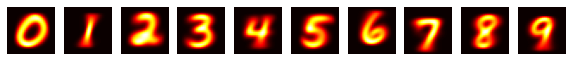

Probability for each digits: tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])


In [9]:
%matplotlib inline
import torch
from matplotlib import pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

transform = transforms.Compose(transforms.ToTensor()) 
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
#initialize counters to count the number of samples for different digits
xcount = torch.ones((784, 10))
ycount = torch.ones(10)

for data, label in mnist_trainset:
  y = int(label)
  ycount[y]+=1
  # resize each sample from (28*28) to 784, 
  # consider each sample has 748 features
  xcount[:,y] += transforms.ToTensor()(data).reshape((784))

py = ycount/ycount.sum() # probability of digits occurance
px = (xcount/ycount.reshape(1,10)) # pixel-wise probability for each digits
fig, figarr = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
  figarr[i].imshow(xcount[:,i].reshape((28,28)).numpy(), cmap='hot')
  figarr[i].axis('off')

plt.show()
print('Probability for each digits:', py)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


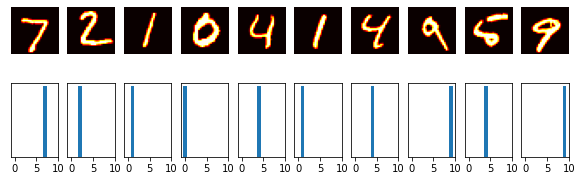

Nive Bayes has an error ate of:  0.1553


In [10]:
logpx = torch.log(px)
logpx_neg = torch.log(1-px)
logpy = torch.log(py)
softmax = torch.nn.Softmax()


def bayespost(data):
  # p(y|x) is proportional to p(x|y)p(y)
  # Then, in log scale, 
  # log(p(y|x)) \propto log(p(y)) + \sum log(px|y)
  logpost = logpy.detach().clone() #p(y)
  # For each feature in x, compute p(x_j|y) element-wise multiplication
  # to compute the per pixel conditional probabilities
  # \sum log(px|y) = logpx*data + logpx_neg*(1-data), where
  # logpx*data: for pixels are on.
  # logpx_neg*(1-data): for pixels are off.
  logpost += (logpx*data + logpx_neg*(1-data)).sum(0)

  logpost -= torch.max(logpost)

  return softmax(logpost)

fig, figarr = plt.subplots(2, 10, figsize=(10, 3))
ctr = 0

for data, label in mnist_testset:
  x = transforms.ToTensor()(data).reshape((784,1))
  y = int(label)
  post = bayespost(x)
  figarr[1, ctr].bar(range(10), post)
  figarr[1, ctr].set_yticks([])
  figarr[1, ctr].set_xticks([0,5,10])
  figarr[0, ctr].imshow(x.reshape((28,28)).numpy(), cmap='hot')
  figarr[0, ctr].axis('off')
  ctr+=1
  if ctr == 10: break
plt.show()

ctr = 0
err = 0

for data, label in mnist_testset:
  ctr += 1
  x = transforms.ToTensor()(data).reshape((784,1))
  y = int(label)
  post = bayespost(x)
  if post[y] < torch.max(post):
    err+=1

print('Nive Bayes has an error ate of: ', err/ctr)